In [1]:
import pickle
from keras.models import load_model

import matplotlib.pyplot as plt
def nice_axis(ax):
    ax.tick_params(which='major',labelsize=18)
    ax.tick_params(direction="in",length=10)
    ax.minorticks_on()
    ax.tick_params(which="minor",direction="in",length=6)
    ax.tick_params(axis='y',which='both',right=True)
    ax.tick_params(axis='x',which='both',top=True)

### Note:
Other than the plotting code, the rest was directly run in terminal on nanna or midway (the high-performance computing cluster at UChicago). So most of the code here did not run in Jupyter Notebook and therefore does not have the output following the cells. 

### Step 1:
- Crop out the central region (size of 210x210) from the orginal image (size of 424x424). 
- Save two versions of the cropped image, one in grayscale and the other in rgb for comparision later.

In [3]:
from PIL import Image
import numpy as np 
import glob

# get all file names within the training data directory
files = glob.glob('/data/andrey/gzoo/images_training_rev1/*.jpg')

for file in files:
    # get the output file path
    outputfile1 = '/data/mandychen/gzoo/images_training_rev1_rgb/'+file.split('/')[5]
    outputfile2 = '/data/mandychen/gzoo/images_training_rev1_gray/'+file.split('/')[5]

    # read image
    im = Image.open(file)
    # convert image to pixel values of R,G,B
    pixels = np.asarray(im)

    lum = np.copy(pixels)
    # crop image
    lum = lum[108:318, 108:318, :]
    Image.fromarray(lum).save(outputfile1)
    
    # convert to grayscale, using "luminosity" method
    lum = 0.21 *lum[:,:,0] + 0.72 * lum[:,:,1] + 0.07 * lum[:,:,2]
    lum = lum.astype(np.uint8)
    Image.fromarray(lum).save(outputfile2)

### Step 2.1:
- From the original training image set, filter away images with Class 1.3>0.03 (i.e., those with >3% of people classified as stars/artifacts).  The threshold of 0.03 is somewhat arbitrary, and it was chosen so that I did not filter away too many galaxies and significantly reduce the sample size, but also filtered away images that are hihgly likely to not be a galaxy. 
 
- Using keras_preprocessing.image.ImageDataGenerator, implement the data augmentation, including spatial down sampling (by a factor of 3x3), random rotation (up to 90 degrees), random horizontal/vertical flipping and random center shift.  I also rescaled the pixel values by 1/255 so that they all fall between 0 and 1. 

- Split the training data set to be 80% used for training, and 20% used for validation.  Together with the filtering based on Class 1.3 value as mentioned above, this leaves us 32802 validated images for training and 10934 images for validation.  In this project, I used the validation images to serve as test images.

### Step 2.2:
- Set up a convolutional neural network and use the grayscale training images to train the network, then use the validation images to test the accuracy. 

Note: the first thing I tried was a fully connected network, similar to the MINST example shown in Michael Nielsen's book.  But the accuracy was only around 57% and I soon discovered that a convolutional neural network is better suited for this type of problem, so I stopped trying fully connected networks and focused on convolutional networks completely. 

In [ ]:
# This was directly run in terminal on nanna/midway

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import pickle
import time

# image augmentation
def append_ext(fn):
    return str(fn)+".jpg"

traindf0 = pd.read_csv("/data/andrey/gzoo/training_solutions_rev1.csv")
traindf = traindf0[traindf0['Class1.3']<0.03] # filter out stars/artifacts
traindf["GalaxyID"] = traindf["GalaxyID"].apply(append_ext)

datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
		dataframe=traindf,
		directory="../images_training_rev1_gray/",
		x_col="GalaxyID",
		y_col=["Class1.1", "Class1.2"],
		subset="training",
		batch_size=32,
		seed=42,
		shuffle=True,
		class_mode="raw",
		target_size=(70,70),
		color_mode="grayscale")

valid_generator=datagen.flow_from_dataframe(
		dataframe=traindf,
		directory="../images_training_rev1_gray/",
		x_col="GalaxyID",
		y_col=["Class1.1", "Class1.2"],
		subset="validation",
		batch_size=32,
		seed=42,
		shuffle=True,
		class_mode="raw",
		target_size=(70,70),
		color_mode="grayscale")

# CNN model construction
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(70,70,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# compile the model and train it
model.compile(optimizer='adam',
	loss='binary_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

tstart = time.time()
epoch_num = 150
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epoch_num)

model.save('../models/model_convnet2.h5')

with open('../models/model_convnet2_hist', 'wb') as file_pi:
	pickle.dump(history.history, file_pi)

print('Finished training for %d epochs in %.1f hrs' % (epoch_num, (time.time()-tstart)/3600.))

#### The architecture of this network is:
(Schematic made with the online tool: http://alexlenail.me/NN-SVG/AlexNet.html )

<center>
<img src="./GalaxyZoo/models/model_convnet2_summary.png" width=900 />

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


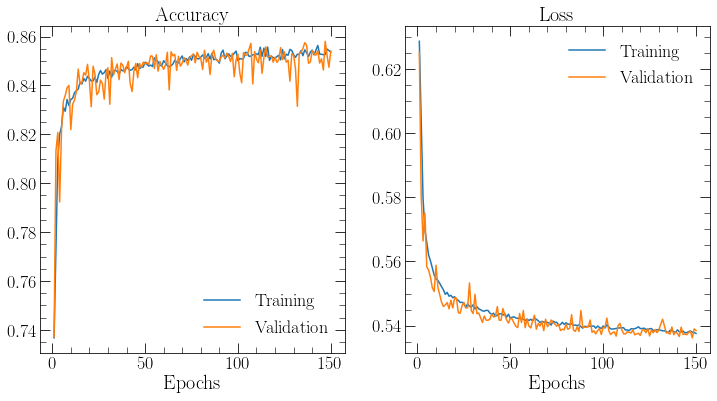

In [3]:
model = load_model('./GalaxyZoo/models/model_convnet2.h5')
model.summary()

history = pickle.load(open('./GalaxyZoo/models/model_convnet2_hist', 'rb'))

acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
ax = axs[0]
ax.plot(epochs, acc, label='Training')
ax.plot(epochs, val_acc, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Accuracy', fontsize=20)
nice_axis(ax)

ax = axs[1]
ax.plot(epochs, loss, label='Training')
ax.plot(epochs, val_loss, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Loss', fontsize=20)
nice_axis(ax)

This model achieves ~85% accuracy.  The validation accuracy follows the training accuracy very closely, indicating that overfitting is not a problem for this neural network.  

Note that when using the validation images to serve as test cases here, they are augmented before feeding into the network.  In principle this is not correct as un-augmented images should be used to test the accuracy. However, I don't expect the results to be very different with un-augmented images.

The derivative of the accuracy is still positive at the end of training (epoch 150). It's possible that if I let this network to train for more epochs, we can continue increase the accuracy.  However, since the potential gain seems to be small, I ended the training at epoch 150, which took ~3 hrs to finish.

### Step 2.3:
- Use rgb images to train the same network

In [ ]:
## This is the same code as before, just changed the images from grayscale to rgb

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
import pandas as pd
import numpy as np
import pickle
import time

def append_ext(fn):
    return str(fn)+".jpg"

traindf0 = pd.read_csv("/scratch/midway3/kravtsov/gzoo/training_solutions_rev1.csv")
traindf = traindf0[traindf0['Class1.3']<0.03] # filter out stars/artifacts
traindf["GalaxyID"] = traindf["GalaxyID"].apply(append_ext)

datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
                dataframe=traindf,
                directory="/home/mandychen/gzoo/images_training_rev1_rgb/",
                x_col="GalaxyID",
                y_col=["Class1.1", "Class1.2"],
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="raw",
                target_size=(70,70),
                color_mode="rgb")

valid_generator=datagen.flow_from_dataframe(
                dataframe=traindf,
                directory="/home/mandychen/gzoo/images_training_rev1_rgb/",
                x_col="GalaxyID",
                y_col=["Class1.1", "Class1.2"],
                subset="validation",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="raw",
                target_size=(70,70),
                color_mode="rgb")


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(70,70,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
        loss='binary_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

tstart = time.time()
epoch_num = 150
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epoch_num)

model.save('/home/mandychen/gzoo/models/model_convnet2_rgb.h5')

with open('/home/mandychen/gzoo/models/model_convnet2_rgb_hist', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

print('Finished training for %d epochs in %.1f hrs' % (epoch_num, (time.time()-tstart)/3600.))
       

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

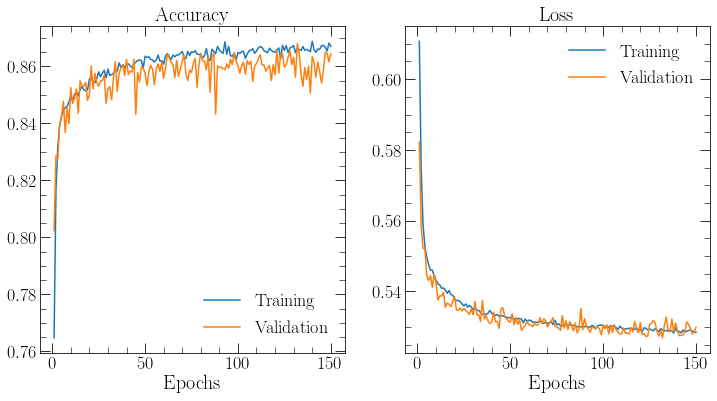

In [5]:
model = load_model('./GalaxyZoo/models/model_convnet2_rgb.h5')
model.summary()

history = pickle.load(open('./GalaxyZoo/models/model_convnet2_rgb_hist', 'rb'))

acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
ax = axs[0]
ax.plot(epochs, acc, label='Training')
ax.plot(epochs, val_acc, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Accuracy', fontsize=20)
nice_axis(ax)

ax = axs[1]
ax.plot(epochs, loss, label='Training')
ax.plot(epochs, val_loss, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Loss', fontsize=20)
nice_axis(ax)

Compared with training with grayscale images, using rgb images increased the accuracy to ~86% for the validation set.  There is an obvious discrepency between the training accuracy and validation accuracy, suggesting that ovefitting is more prominent in when using rgb images. 

### Step 3:
- Use a pretrained convolutional network to train on this data set.

- Following the example in Chapt. 5.3 of Francois Chollet's book, I tried VGG16 and froze all the convolution layers, and only allow the final dense layers to be trainable. 

In [ ]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.applications import VGG16
import pandas as pd
import numpy as np
import pickle
import time

def append_ext(fn):
    return str(fn)+".jpg"

traindf0 = pd.read_csv("/data/andrey/gzoo/training_solutions_rev1.csv")
traindf = traindf0[traindf0['Class1.3']<0.03] # filter out stars/artifacts
traindf["GalaxyID"] = traindf["GalaxyID"].apply(append_ext)

datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
		dataframe=traindf,
		directory="../images_training_rev1_rgb/",
		x_col="GalaxyID",
		y_col=["Class1.1", "Class1.2"],
		subset="training",
		batch_size=32,
		seed=42,
		shuffle=True,
		class_mode="raw",
		target_size=(70,70),
		color_mode="rgb")

valid_generator=datagen.flow_from_dataframe(
		dataframe=traindf,
		directory="../images_training_rev1_rgb/",
		x_col="GalaxyID",
		y_col=["Class1.1", "Class1.2"],
		subset="validation",
		batch_size=32,
		seed=42,
		shuffle=True,
		class_mode="raw",
		target_size=(70,70),
		color_mode="rgb")

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(70, 70, 3))
conv_base.trainable = False
# conv_base.summary()

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
	loss='binary_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

tstart = time.time()
epoch_num = 50
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epoch_num)

model.save('../models/model_convnet4.h5')

with open('../models/model_convnet4_hist', 'wb') as file_pi:
	pickle.dump(history.history, file_pi)

print('Finished training for %d epochs in %.1f hrs' % (epoch_num, (time.time()-tstart)/3600.))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 14,977,218
Trainable params: 262,530
Non-trainable params: 14,714,688
_________________________________________________________________


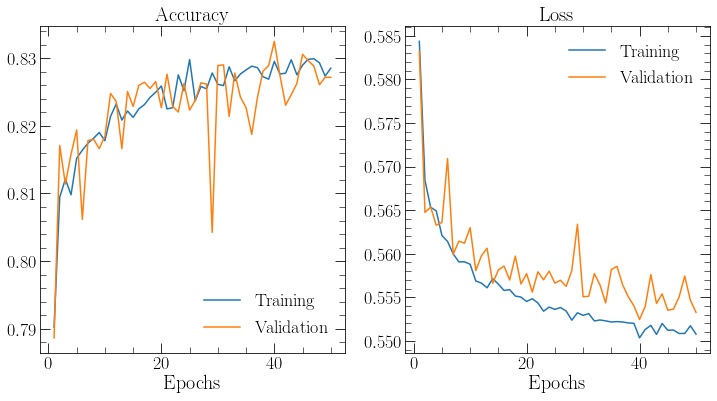

In [8]:
model = load_model('./GalaxyZoo/models/model_convnet4.h5')
model.summary()

history = pickle.load(open('./GalaxyZoo/models/model_convnet4_hist', 'rb'))

acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
ax = axs[0]
ax.plot(epochs, acc, label='Training')
ax.plot(epochs, val_acc, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Accuracy', fontsize=20)
nice_axis(ax)

ax = axs[1]
ax.plot(epochs, loss, label='Training')
ax.plot(epochs, val_loss, label='Validation')
ax.legend(fontsize=18, frameon=False)
ax.set_xlabel('Epochs', fontsize=20)
ax.set_title('Loss', fontsize=20)
nice_axis(ax)

As a quick test, I only train this network for 50 epochs and the accuracy is around 83%.  This accuracy is lower than what was achieved by the CNN described above at epoch 50.  The lower accuracy suggests that the learned parameters in the convolutional layers in VGG16 does not work well for this particular data set.  It's possible to improve the performance by fine-tuning the parameters in the convolutional layers.  But due to time limitation, I did not test it out. 

### Some other notes:

- I have also tried different architecture design for the network, including a different number of convolutiona/dense layers, different size choices for the filter map, different number of nodes in the dense layers, etc. Increasing the size of the network and the number of parameters doesn't always lead to a higher accuracy.  So far the model I showed aboved has the best performance among my attempts. 

- I have been using the binary_cross_entropy loss function, the default training rate from the adam optimizer, the softmax activation function for the output dense layer, and a dropout of 0.5 after each fully connect dense layer (except for the last one) to limit overfitting. From the readings I have done, KL divergence could also be a good loss function for this data set, and sigmoid will perform similary as the output activation. The learning rate could also be adjusted and time varying learning rate could potentially be applied to achieve a better result. Additional regularization (e.g., L2) could also be applied to better limit the overfitting present in some of the models I tried. Due to the time limitation and the fact that the model I showed above already has a satisfactory performance, I did not experiment with all these factors. 